In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow-addons==0.8.1
# !pip install numpy
# !pip install opencv-python
!pip install scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ----------- ---------------------------- 3.1/11.0 MB 18.5 MB/s eta 0:00:01
   ---------------------------- ----------- 7.9/11.0 MB 21.2 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 19.7 MB/s eta 0:00:00


In [1]:
import numpy as np
import os
import cv2
import pickle
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob 

# Define paths
BASE_PATH = "./Tumor/"
TRAIN_PATH = os.path.join(BASE_PATH, "Train")
VAL_PATH = os.path.join(BASE_PATH, "Val")

print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

def load_data_from_directory(directory):
    for class_name in ["Glioma", "Meningioma", "Pituitary"]:
        class_path = os.path.join(directory, class_name)
        images_path = os.path.join(class_path, "images")
        labels_path = os.path.join(class_path, "labels")
        
        for imagePath in glob.glob(os.path.join(images_path, "*.jpg")):
            # Get the corresponding label file
            labelPath = os.path.join(labels_path, os.path.splitext(os.path.basename(imagePath))[0] + ".txt")
            
            if not os.path.exists(labelPath):
                print(f"Warning: Label file not found for {imagePath}")
                continue
            
            # Read the image
            image = cv2.imread(imagePath)
            if image is None:
                print(f"Warning: Could not read image {imagePath}")
                continue
            
            (h, w) = image.shape[:2]
            
            # Read the YOLO format label
            try:
                with open(labelPath, 'r') as f:
                    line = f.readline().strip().split()
                    if not line:
                        print(f"Warning: Empty label file {labelPath}")
                        continue
                    
                    class_id = int(line[0])
                    
                    # YOLO format: center_x, center_y, width, height
                    center_x, center_y, bbox_width, bbox_height = map(float, line[1:])
            except Exception as e:
                print(f"Error reading label file {labelPath}: {str(e)}")
                continue
            
            # Convert YOLO format to (startX, startY, endX, endY)
            startX = (center_x - bbox_width/2) 
            startY = (center_y - bbox_height/2)
            endX = (center_x + bbox_width/2)
            endY = (center_y + bbox_height/2)
            
            # Resize the image to 224x224
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            
            data.append(image)
            labels.append(class_name)
            bboxes.append((startX, startY, endX, endY))
            imagePaths.append(imagePath)

# Load training data
print("Loading training data...")
load_data_from_directory(TRAIN_PATH)

# Load validation data
print("Loading validation data...")
load_data_from_directory(VAL_PATH)

data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

if len(lb.classes_) == 2:
    labels = to_categorical(labels)

# Splitting dataset (optional, since we already have a validation set)
trainImages, testImages, trainLabels, testLabels, trainBBoxes, testBBoxes, trainPaths, testPaths = train_test_split(
    data, labels, bboxes, imagePaths, test_size=0.2, random_state=42, stratify=labels
)

print("[INFO] Dataset loaded and preprocessed.")
print(f"Training samples: {len(trainImages)}")
print(f"Testing samples: {len(testImages)}")

[INFO] loading dataset...
Loading training data...
Loading validation data...
[INFO] Dataset loaded and preprocessed.
Training samples: 3549
Testing samples: 888


In [2]:
trainImages.shape, testImages.shape, trainBBoxes.shape

((3549, 224, 224, 3), (888, 224, 224, 3), (3549, 4))

## ViT

In [3]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "patch_size": self.patch_size,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

In [5]:
import sys
print(sys.version)
import tensorflow as tf
print(tf.__version__)

3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]
2.12.0


C:\Users\vxk2051.UTA\AppData\Local\anaconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


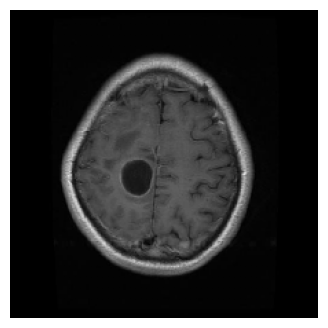

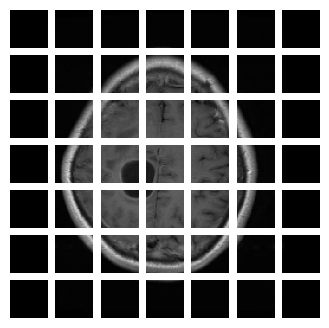

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
patch_size = 32
image_size = 224
# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(trainImages[0])  
plt.axis("off")  

# Extract patches from the image using the 'Patches' layer
patches = Patches(patch_size)(tf.convert_to_tensor([trainImages[0]]))

# Print information about the image and patch sizes
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

# Calculate the number of patches to be displayed in each row and column
n = int(np.sqrt(patches.shape[1]))

# Create a new figure for displaying the extracted patches
plt.figure(figsize=(4, 4))

# Iterate through and display each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)  # Create a subplot
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))  # Reshape the patch to image dimensions
    plt.imshow(patch_img.numpy())  # Display the patch as an image
    plt.axis("off") 

In [7]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches

        self.projection = layers.Dense(units=projection_dim)

        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "num_patches": num_patches,
                "projection_dim": projection_dim,
            }
        )
        return config

    def call(self, patch):
        # Create positions for the patches
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [8]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes
):
    inputs = layers.Input(shape=input_shape)
    

    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # Apply an MLP to the output
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    
    # Add an additional MLP for feature extraction
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    # Bounding box output layer
    bounding_box = layers.Dense(4, name='bbox')(features)  # Assuming normalized coordinates for bounding boxes

    # Classification output layer
    classification = layers.Dense(num_classes, activation='softmax', name='classification')(features)

    # Return the Keras model with both outputs
    return keras.Model(inputs=inputs, outputs=[classification, bounding_box])

In [9]:
import tensorflow as tf
import keras.backend as K
def loss_GIoU(output, target):
    loss = K.square(output - target)

    # Extract the x and y coordinates of the predicted and true bounding boxes
    pr_x1, pr_y1, pr_x2, pr_y2 = tf.split(output, num_or_size_splits=4, axis=-1)
    tr_x1, tr_y1, tr_x2, tr_y2 = tf.split(target, num_or_size_splits=4, axis=-1)

    # Ensure pred_x2 > pred_x1 and pred_y2 > pred_y1 for predicted bounding box
    pred_x1 = tf.minimum(pr_x1, pr_x2)
    pred_x2 = tf.maximum(pr_x1, pr_x2)
    pred_y1 = tf.minimum(pr_y1, pr_y2)
    pred_y2 = tf.maximum(pr_y1, pr_y2)

    # Ensure true_x2 > true_x1 and true_y2 > true_y1 for true bounding box
    true_x1 = tf.minimum(tr_x1, tr_x2)
    true_x2 = tf.maximum(tr_x1, tr_x2)
    true_y1 = tf.minimum(tr_y1, tr_y2)
    true_y2 = tf.maximum(tr_y1, tr_y2)

    # Calculate area of true and predicted bounding boxes
    trueArea = (true_x2 - true_x1) * (true_y2 - true_y1)
    predArea = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)

    # Calculate intersection between true and predicted bounding boxes
    inter_x1 = tf.maximum(pred_x1, true_x1)
    inter_x2 = tf.minimum(pred_x2, true_x2)
    inter_y1 = tf.maximum(pred_y1, true_y1)
    inter_y2 = tf.minimum(pred_y2, true_y2)

    # Check if there is any intersection, if not, set intersection to zero
    interArea = tf.maximum(0.0, inter_x2 - inter_x1) * tf.maximum(0.0, inter_y2 - inter_y1)

    # Find coordinate of the smallest enclosing box
    small_x1 = tf.minimum(pred_x1, true_x1)
    small_x2 = tf.maximum(pred_x2, true_x2)
    small_y1 = tf.minimum(pred_y1, true_y1)
    small_y2 = tf.maximum(pred_y2, true_y2)

    # Calculate area of smallest enclosing box
    smallArea = (small_x2 - small_x1) * (small_y2 - small_y1)

    # Calculate union and IoU, handling the case where both boxes have zero area
    union = predArea + trueArea - interArea + 1e-7
    IoU = interArea / union
    penalty = tf.where(tf.less(union, 1e-7), trueArea, tf.zeros_like(union))
    GIoU = IoU - ((smallArea - union) / (smallArea + penalty))

    # return GIoU as loss
    return 1 - GIoU+loss

In [10]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs, trainImages, trainBBoxes, trainLabels):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    # Compile the model with multiple losses
    model.compile(
        optimizer=optimizer,
        loss={
            'bbox': loss_GIoU,#keras.losses.MeanSquaredError(),
            'classification': keras.losses.CategoricalCrossentropy()
        },
        metrics={
            'bbox': [keras.metrics.MeanAbsoluteError()],
            'classification': [keras.metrics.CategoricalAccuracy()]
        }
    )

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    # Assuming trainBBoxes and trainLabels are provided correctly formatted
    history = model.fit(
        x=trainImages,
        y={'bbox': trainBBoxes, 'classification': trainLabels},
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)],
    )

    return history

# Define input image shape and training hyperparameters
input_shape = (image_size, image_size, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 25
num_classes = trainLabels.shape[1]

# Calculate the number of patches
num_patches = (image_size // patch_size) ** 2

# Define the dimensions and layers for the Vision Transformer (ViT) model
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 6
mlp_head_units = [2048, 1024, 512, 64, 32]

# Initialize a list to store training history
history = []

# Create a ViT-based object detection model
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes
)

# Train the model and store the training history
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs, trainImages, trainBBoxes, trainLabels
)

Epoch 1/25
100/100 [==============================] - 33s 259ms/step - loss: 3.0721 - classification_loss: 1.1792 - bbox_loss: 1.8929 - classification_categorical_accuracy: 0.3225 - bbox_mean_absolute_error: 0.4822 - val_loss: 2.2766 - val_classification_loss: 1.0997 - val_bbox_loss: 1.1768 - val_classification_categorical_accuracy: 0.3493 - val_bbox_mean_absolute_error: 0.2002
Epoch 2/25
100/100 [==============================] - 25s 248ms/step - loss: 2.4915 - classification_loss: 1.1118 - bbox_loss: 1.3797 - classification_categorical_accuracy: 0.3557 - bbox_mean_absolute_error: 0.3138 - val_loss: 2.1479 - val_classification_loss: 1.1053 - val_bbox_loss: 1.0426 - val_classification_categorical_accuracy: 0.3352 - val_bbox_mean_absolute_error: 0.2910
Epoch 3/25
100/100 [==============================] - 25s 247ms/step - loss: 2.2019 - classification_loss: 1.0969 - bbox_loss: 1.1050 - classification_categorical_accuracy: 0.3406 - bbox_mean_absolute_error: 0.2618 - val_loss: 2.1257 - va

## Model Evaluation

### Accuracy, Loss plots

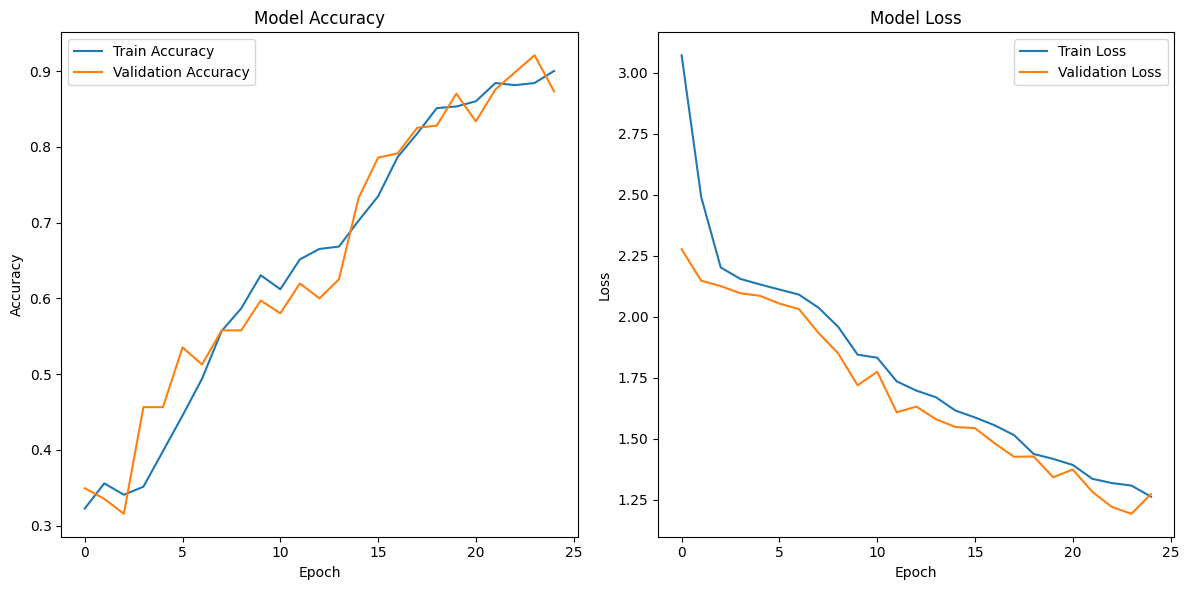

In [11]:

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_classification_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### confusion matrix

28/28 [==============================] - 3s 67ms/step


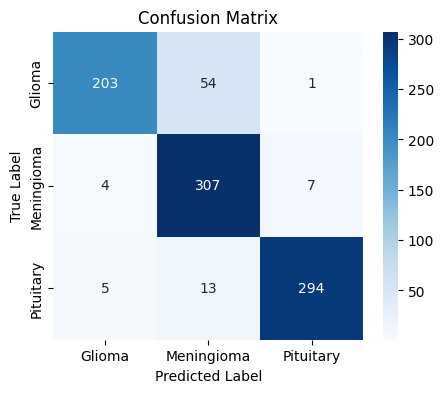

In [12]:

predictions = vit_object_detector.predict(testImages)

predicted_labels = np.argmax(predictions[0], axis=1)
from sklearn.metrics import confusion_matrix
import numpy as np

true_labels_indices = np.argmax(testLabels, axis=1) 

cm = confusion_matrix(true_labels_indices, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Glioma", "Meningioma", "Pituitary"], yticklabels=["Glioma", "Meningioma", "Pituitary"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [13]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

def compute_iou(boxA, boxB):
    assert len(boxA) == 4 and len(boxB) == 4, "Both boxes must have four coordinates"
    
    # Calculate coordinates for the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calculate the area of intersection
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union by dividing the intersection area by the sum of both areas minus their intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


preds = vit_object_detector.predict(testImages, batch_size=32)

#predictions
predicted_bboxes = preds[1]
predicted_labels = np.argmax(preds[0], axis=1)
true_labels = np.argmax(testLabels, axis=1)

# Calculate IoUs and accuracies
ious = np.array([compute_iou(predicted_bboxes[i], testBBoxes[i]) for i in range(len(testBBoxes))])
label_accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print(f"Mean IoU: {np.mean(ious)}")
print(f"Label Accuracy: {label_accuracy}")


28/28 [==============================] - 2s 66ms/step
Mean IoU: 0.5104609710739995
Label Accuracy: 0.9054054054054054


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import accuracy_score
import matplotlib.patches as patches

def calculate_mean_iou_and_label_accuracy_with_details(model, testImages, testBBoxes, testLabels):
    predictions = model.predict(testImages)
    predicted_bboxes = predictions[1]
    predicted_labels_indices = np.argmax(predictions[0], axis=1)
    true_labels_indices = np.argmax(testLabels, axis=1)

    # Calculate IoUs for each prediction
    ious = []
    for i in range(len(testBBoxes)):
        iou = compute_iou(predicted_bboxes[i], testBBoxes[i])
        ious.append(iou)
    
    mean_iou = np.mean(ious)
    label_accuracy = accuracy_score(true_labels_indices, predicted_labels_indices)
    
    return ious, mean_iou, label_accuracy


# Calculate IoUs, mean IoU, and label accuracy
ious, mean_iou, label_accuracy = calculate_mean_iou_and_label_accuracy_with_details(vit_object_detector, testImages, testBBoxes, testLabels)

# DataFrame to display IoUs in a table format
iou_df = pd.DataFrame({'Image Index': np.arange(1, len(ious) + 1), 'IoU': ious})
print(iou_df)

# Print the mean IoU and label accuracy
print(f"\nMean IoU: {mean_iou:.4f}")
print(f"Label Accuracy: {label_accuracy:.4f}")

28/28 [==============================] - 2s 66ms/step
     Image Index       IoU
0              1  0.403843
1              2  0.678497
2              3  0.402386
3              4  0.396755
4              5  0.492200
..           ...       ...
883          884  0.508198
884          885  0.405220
885          886  0.666654
886          887  0.748209
887          888  0.678753

[888 rows x 2 columns]

Mean IoU: 0.5105
Label Accuracy: 0.9054


28/28 [==============================] - 2s 63ms/step
Mean IoU: 0.5104609710739995
Label Accuracy: 0.9054054054054054


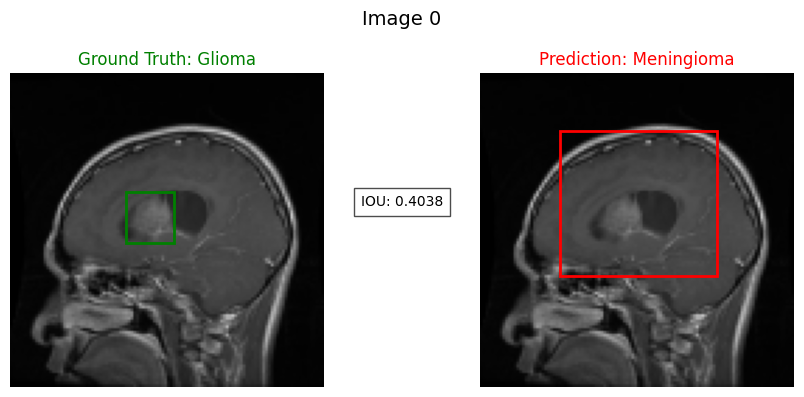

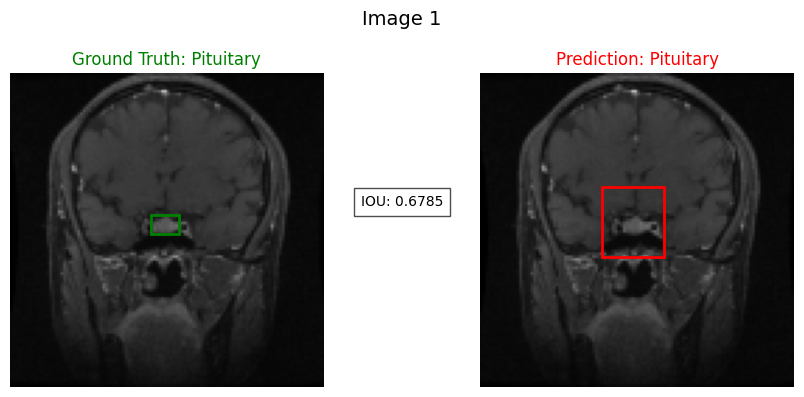

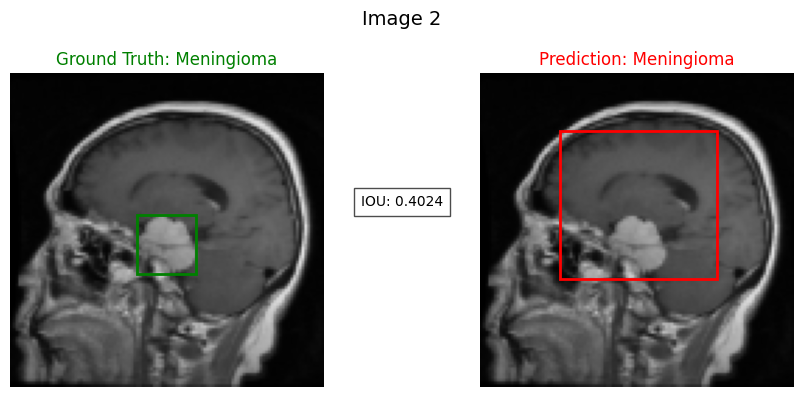

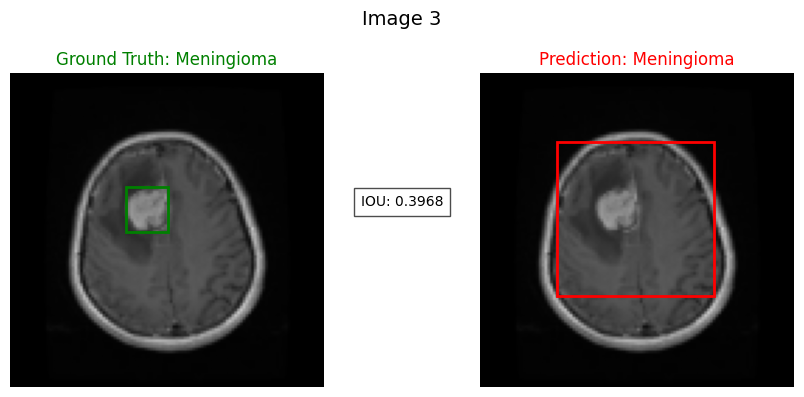

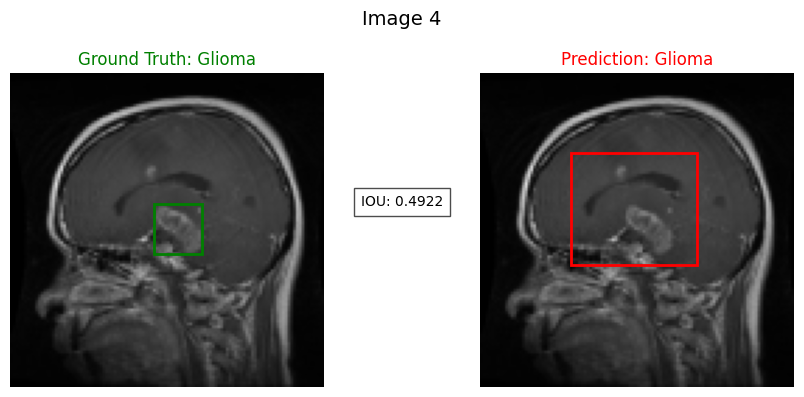

In [20]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.transform import resize


def visualize_predictions(image, true_bbox, pred_bbox, true_label, pred_label, iou, index):
    # Reduce image size by 50%
    new_height, new_width = int(image.shape[0] * 0.5), int(image.shape[1] * 0.5)
    resized_image = resize(image, (new_height, new_width), anti_aliasing=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) 

    #This function reduce size of image to be printed on cell, so it will be easy to compare 
    def bbox_to_pixels_adjusted(bbox, width, height):
        if np.all(bbox <= 1.0):
            return [
                int(bbox[0] * width),
                int(bbox[1] * height),
                int(bbox[2] * width) - 1,
                int(bbox[3] * height) - 1
            ]
        return [int(bbox[0] * 0.5), int(bbox[1] * 0.5), int(bbox[2] * 0.5) - 1, int(bbox[3] * 0.5) - 1]
    
    true_bbox_pixels = bbox_to_pixels_adjusted(true_bbox, new_width, new_height)
    pred_bbox_pixels = bbox_to_pixels_adjusted(pred_bbox, new_width, new_height)
    
    # Ground Truth
    ax1.imshow(resized_image, cmap='gray')
    rect = patches.Rectangle((true_bbox_pixels[0], true_bbox_pixels[1]), true_bbox_pixels[2] - true_bbox_pixels[0] + 1, true_bbox_pixels[3] - true_bbox_pixels[1] + 1,linewidth=2, edgecolor='g', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title(f"Ground Truth: {label_map[true_label]}", color='g')
    ax1.axis('off')
    
    # Prediction
    ax2.imshow(resized_image, cmap='gray')
    rect = patches.Rectangle((pred_bbox_pixels[0], pred_bbox_pixels[1]), pred_bbox_pixels[2] - pred_bbox_pixels[0] + 1, pred_bbox_pixels[3] - pred_bbox_pixels[1] + 1,linewidth=2, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
    ax2.set_title(f"Prediction: {label_map[pred_label]}", color='r')
    ax2.axis('off')
    
    plt.figtext(0.5, 0.5, f"IOU: {iou:.4f}", ha="center", va="center", fontsize=10, 
                bbox={"facecolor":"white", "edgecolor":"black", "alpha":0.7, "pad":5})
    
    plt.suptitle(f"Image {index}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Label mapping
label_map = ["Glioma", "Meningioma", "Pituitary"]

preds = vit_object_detector.predict(testImages, batch_size=32)
predicted_bboxes = preds[1]
predicted_labels = np.argmax(preds[0], axis=1)
true_labels = np.argmax(testLabels, axis=1)

ious = np.array([compute_iou(testBBoxes[i], predicted_bboxes[i]) for i in range(len(testBBoxes))])
label_accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Mean IoU: {np.mean(ious)}")
print(f"Label Accuracy: {label_accuracy}")


for i in range(min(5, len(testImages))):
    visualize_predictions(testImages[i], testBBoxes[i], predicted_bboxes[i], true_labels[i], predicted_labels[i], ious[i], i)